# <span style="font-family: 'Computer Modern'; font-size: 42pt; font-weight: bold;">Quantum Convolutional Neural Network (QCNN): *Laboratory of Particle Physics and Cosmology (LPPC)*</span>

In [1]:
### ***** IMPORTS / DEPENDENCIES *****:

## PLOTTING:
import matplotlib as mpl # (NOT ACCESSED)
import matplotlib.pyplot as plt

## PENNYLANE:
import pennylane as qml
from pennylane import numpy as np

## DATA:
import numpy as np
import seaborn as sns

## JAX:
import jax;
## JAX CONFIGURATIONS:
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
# import jax.experimental.sparse as jsp # (NOT ACCESSED)
# import jax.scipy.linalg as jsl  # (NOT ACCESSED)

## OTHER:
sns.set()
seed = 0
rng = np.random.default_rng(seed=seed)
# from glob import glob

In [2]:
### ***** PACKAGE IMPORTS (IN PROGRESS) *****:
# ****************************************************************************************
## *1* MNIST DATA LOADING CLASS:
# from lppc_qcnn.load_qc_data import LoadDataQC # LoadDataQC() <--- STATIC METHOD

## *2* QUANTUM CIRCUIT AND LAYERS CLASS:
# from lppc_qcnn.circuit_layers import LayersQC # LayersQC() <--- INSTANCE METHOD (SELF)
# -> Define Instance of LayersQC:
# layers_obj = LayersQC()

## *3* TRAIN QCNN / RESULTS CLASS:
# from lppc_qcnn.circuit_layers import TrainQC # TrainQC() <--- INSTANCE METHOD (SELF)
# -> Define Instance of TrainQC:
# layers_obj = TrainQC()

# TO-DO
# ****************************************************************************************

<span style="font-family: 'Computer Modern'; font-weight: bold; font-size: 24pt;">LOADING MNIST DATASET</span>

In [3]:
# ********************************************
#           INITIAL PARAMETER SETUP
# ********************************************

## MNIST DATA LOADING CLASS:
from lppc_qcnn.load_qc_data import LoadDataQC # <--- STATIC METHOD

## DEFINE VARIABLES:
n_qubits = 6 # Number of qubits
active_qubits = 6 # Active qubits
# active_qubits = list(range(active_qubits))
num_wires = 6 # Number of wires
num_wires_draw = 2 # Number of wires (DRAWINGS)
# num_wires_test = 4 # Number of wires (TEST)

## QUANTUM DEVICE:
# device = qml.device("default.mixed", wires=num_wires)
device = qml.device("default.qubit", wires=num_wires) # Six-qubit device

In [4]:
# ********************************************
#          LOADING THE MNIST DATASET
# ********************************************

## DEFINE VARIABLES (DATA):
num_train = 2 # Binary classification
num_test = 2

# Call static method of [LoadDataQC] to load data (digits):
x_train, y_train, x_test, y_test = LoadDataQC.load_digits_data(num_train, num_test, rng)

##           *** FUNCTIONALITY CHECK PRINT STATEMENTS (DATA) ***
# -------------------------------------------------------------------------
print(f"{'='*15} FUNCTIONALITY CHECK (DATA) {'='*15}")

# Shapes and Types:
print(f"\n{'='*14} (1) SHAPES AND TYPES {'='*14}")
print(f"• x_train type:  {type(x_train)}  | shape:  {x_train.shape}")
print(f"• y_train type:  {type(y_train)}  | shape:  {y_train.shape}")
print(f"• x_test type:  {type(x_test)}  | shape:  {x_test.shape}")
print(f"• y_test type:  {type(y_test)}  | shape:  {y_test.shape}")

# Normalization:
print(f"\n{'='*10} (2) NORMALIZATION {'='*10}")
print(f"• x_train first row norm:  {np.linalg.norm(x_train[0])}")
print(f"• x_test first row norm:  {np.linalg.norm(x_test[0])}")

# Label Uniqueness:
print(f"\n{'='*10} (3) LABEL UNIQUENESS {'='*10}")
print(f"• Unique labels -> y_train:  {np.unique(y_train)}")
print(f"• Unique labels -> y_test:  {np.unique(y_test)}")
# -------------------------------------------------------------------------

=============== FUNCTIONALITY CHECK (DATA) ===============

============== (1) SHAPES AND TYPES ==============
• x_train type:  <class 'jaxlib.xla_extension.ArrayImpl'>  | shape:  (2, 64)
• y_train type:  <class 'jaxlib.xla_extension.ArrayImpl'>  | shape:  (2,)
• x_test type:  <class 'jaxlib.xla_extension.ArrayImpl'>  | shape:  (2, 64)
• y_test type:  <class 'jaxlib.xla_extension.ArrayImpl'>  | shape:  (2,)

========== (2) NORMALIZATION ==========
• x_train first row norm:  1.0
• x_test first row norm:  1.0

========== (3) LABEL UNIQUENESS ==========
• Unique labels -> y_train:  [1]
• Unique labels -> y_test:  [0 1]


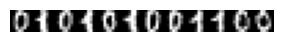

In [5]:
# ********************************************
#        VISUALIZING THE MNIST DATASET
# ********************************************

## DRAW MNIST IMAGE:
LoadDataQC.draw_mnist_data()

<span style="font-family: 'Computer Modern'; font-weight: bold; font-size: 24pt;">CONSTRUCTING QUANTUM CIRCUIT</span>

In [6]:
# ********************************************
#    VISUALIZING / PLOTTING QUANTUM CIRCUIT
# ********************************************

## QUANTUM CIRCUIT AND LAYERS CLASS:
from lppc_qcnn.circuit_layers import LayersQC # <--- INSTANCE METHOD (SELF)
# Define Instance of LayersQC:
layers_obj = LayersQC()

## DEFINE SAMPLE WEIGHTS / FEATURES:
# (Note: Adjust second dimension as needed)
weights = np.random.rand(81, 2) # <--- SHAPE ~ [(num_wires // 2) * (3 ** 3)]
# weights = np.random.rand(num_wires, 2)
last_layer_weights = np.random.rand(4 ** 2 - 1)
# last_layer_weights = np.random.rand(4 ** (num_wires // 2) - 1)
features = np.random.rand(2 ** num_wires)

## DRAW CIRCUIT:
fig, ax = qml.draw_mpl(layers_obj.conv_net)(
layers_obj, weights, last_layer_weights, features
)

plt.show()

TypeError: QuantumMathOps.b_mat() missing 1 required positional argument: 'n'

In [ ]:
# ********************************************
#           TRAINING QCNN / RESULTS
# ********************************************

## TRAINING QCNN CLASS:
from lppc_qcnn.circuit_layers import TrainQC # TrainQC() <--- INSTANCE METHOD (SELF)
# Define Instance of TrainQC:
# train_obj = TrainQC
train_obj = TrainQC()

## DEFINE TRAIN PARAMETERS:
n_test = 2
n_train = 2
n_epochs = 100
n_reps = 10

# Run training for multiple sizes and aggregate results:
results_df = train_obj.compute_aggregated_results(train_obj, n_train, n_test)
## ALTERNATES:
# results_df = train_obj.compute_aggregated_results(n_train, n_test)
# results_df = train_obj.compute_aggregated_results(n_train=n_train, n_test=n_test)

In [ ]:
# ********************************************
#     PLOTTING AGGREGATED TRAINING RESULTS
# ********************************************

## DEFINE TRAIN PARAMETERS (ALSO ABOVE):
# n_test = 2
n_train = 2
n_epochs = 100
steps = 100
# train_obj = TrainQC() (RECALL)

# Plot aggregated training results:
train_obj.plot_aggregated_results(train_obj, results_df, n_train, steps=n_epochs, 
                                  title_loss='Train and Test Losses', 
                                  title_accuracy='Train and Test Accuracies', 
                                  markevery=10)
## ALTERNATES:
# train_obj.plot_aggregated_results(results_df, n_train, steps, 
#                                   title_loss='Train and Test Losses', 
#                                   title_accuracy='Train and Test Accuracies', 
#                                   markevery=10) # (NO SELF)
# train_obj.plot_aggregated_results(results_df, n_train=n_train, steps=steps, 
#                                   title_loss='Train and Test Losses', 
#                                   title_accuracy='Train and Test Accuracies', 
#                                   markevery=10)

***

<span style="font-family: 'Computer Modern'; font-weight: bold; font-size: 24pt;">CODE TESTING / VALIDATION</span>

In [ ]:
# a = x_train[0]

# **************************************************************************************************

# print(type(a))

# **************************************************************************************************

# full_array = jnp.array(
#         [
#             [
#                 [0,0,0],
#                 [2,2,2],
#                 [0,0,0],
#                 [0,0,0]
#             ],
#             [
#                 [1,1,1],
#                 [0,0,0],
#                 [0,0,0],
#                 [0,0,0]
#             ],
#             [
#                 [1,1,1],
#                 [0,0,0],
#                 [0,0,0],
#                 [0,0,0]
#             ]
#         ]
# )

***